<a href="https://colab.research.google.com/github/anishasingh23/stockPricePred/blob/main/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1**

In [2]:
!pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.8 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed

Running Algorithmic Trading Bot for AAPL
Version 1.0.2 (Fixed data feed issue)
Fetching data for AAPL from 2020-01-01 to 2023-01-01...
Retrieved 756 data points

==== Stock Data Preview ====
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716064  72.776591  71.466805  71.721011  135480400
2020-01-03  72.009117  72.771745  71.783962  71.941328  146322800
2020-01-06  72.582916  72.621654  70.876083  71.127873  118387200
2020-01-07  72.241539  72.849216  72.021223  72.592586  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200

==== Stock Data Statistics ====
Price        Close        High         Low        Open        Volume
Ticker        AAPL        AAPL        AAPL        AAPL          AAPL
count   756.000000  756.000000  756.000000  756.000000  7.560000e+02
mean    127.800473  129.350921  126.13662

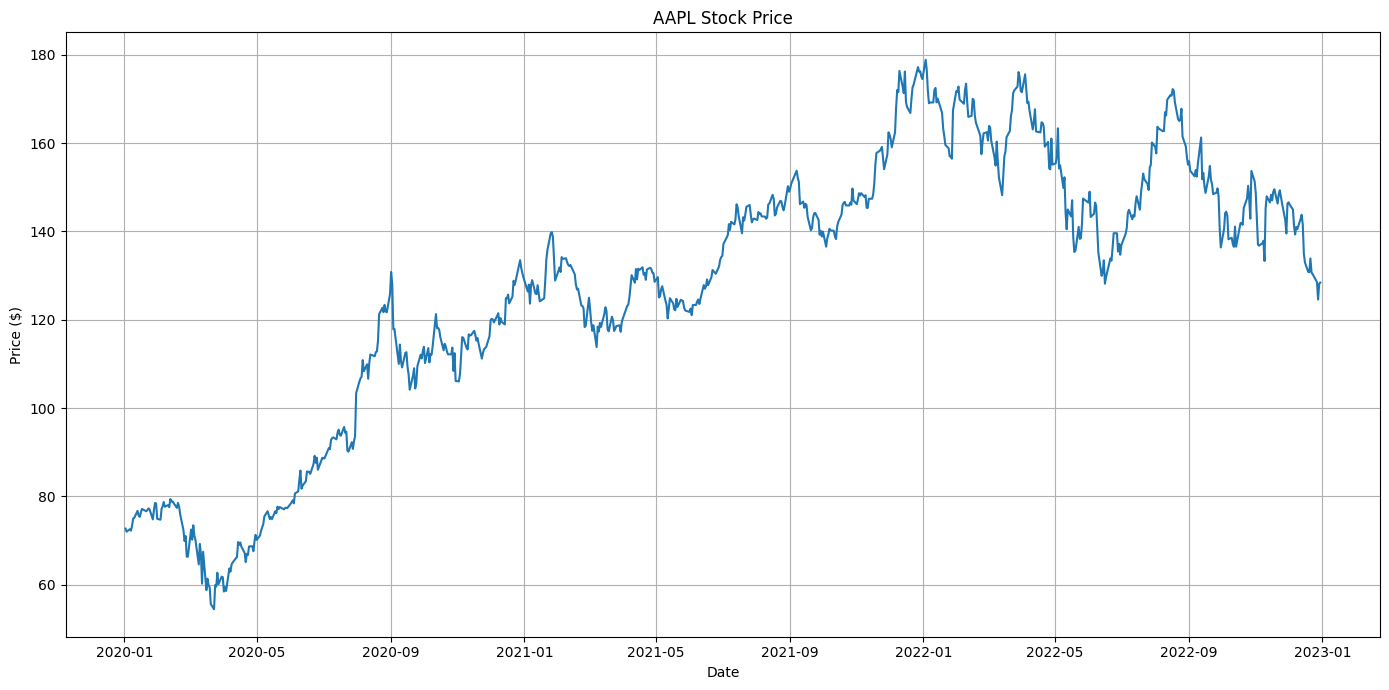


==== Training LSTM Price Predictor ====
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.1243 - val_loss: 0.0181
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0124 - val_loss: 0.0035
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0072 - val_loss: 0.0034
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0058 - val_loss: 0.0032
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0062 - val_loss: 0.0032
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0053 - val_loss: 0.0029
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 12/50
18/18 ━━━

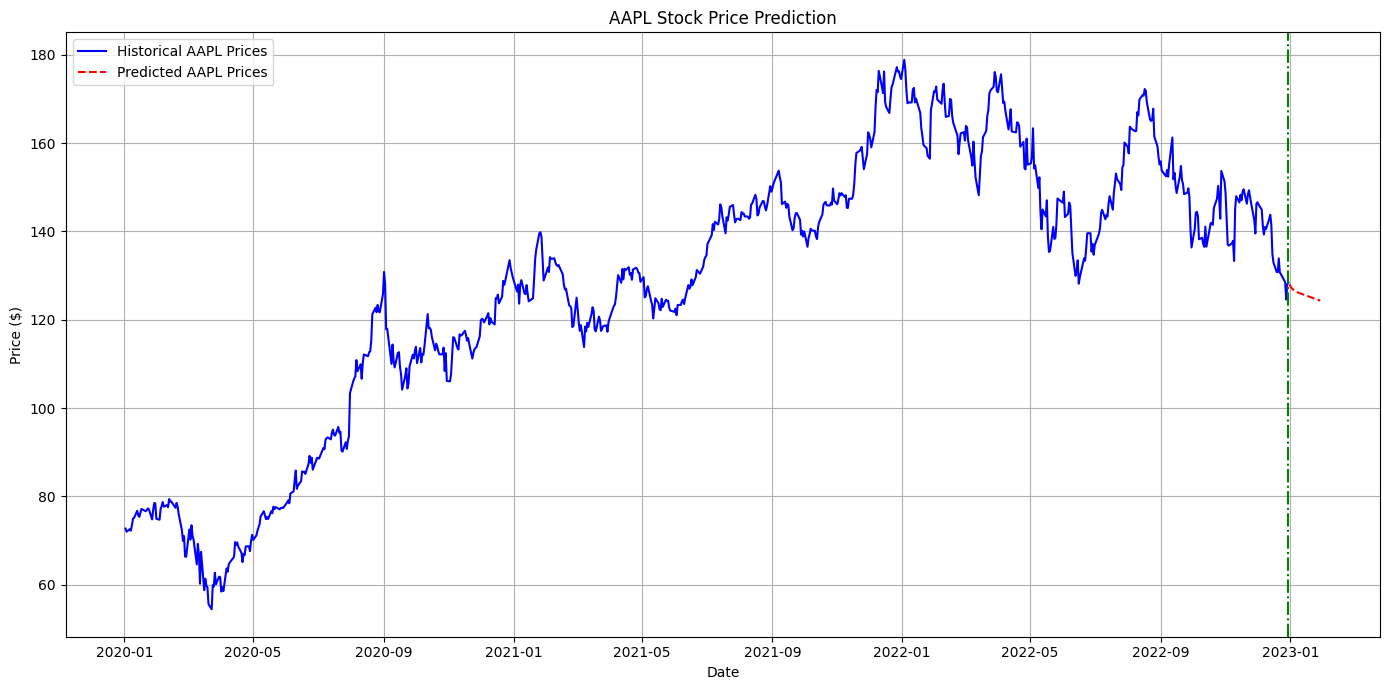


==== Running Strategy Backtests ====

--- VWAP Strategy ---
Starting Portfolio Value: $100000.00
Error: time data '' does not match format '%Y-%m-%d'
Please check the input parameters and try again.
Cleaned up temporary files.

Algorithmic Trading Bot execution completed!


In [5]:


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import backtrader as bt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class StockPricePredictor:
    """LSTM-based stock price predictor for time series forecasting"""

    def __init__(self, lookback_days=60):
        self.lookback_days = lookback_days
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def _prepare_data(self, stock_data, target_col='Close'):
        """Prepare data for LSTM model"""
        # Extract target column and convert to numpy array
        data = stock_data[target_col].values.reshape(-1, 1)

        # Scale the data
        scaled_data = self.scaler.fit_transform(data)

        # Create features (X) and target (y)
        X, y = [], []
        for i in range(self.lookback_days, len(scaled_data)):
            X.append(scaled_data[i-self.lookback_days:i, 0])
            y.append(scaled_data[i, 0])

        # Convert to numpy arrays
        X, y = np.array(X), np.array(y)

        # Reshape for LSTM [samples, time steps, features]
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, y

    def build_model(self, input_shape):
        """Build LSTM model architecture"""
        model = Sequential()

        # First LSTM layer with dropout
        model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))

        # Second LSTM layer with dropout
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(units=1))

        # Compile model
        model.compile(optimizer='adam', loss='mean_squared_error')

        return model

    def train(self, stock_data, target_col='Close', test_size=0.2, epochs=50, batch_size=32, verbose=1):
        """Train the LSTM model"""
        # Prepare data
        X, y = self._prepare_data(stock_data, target_col)

        # Split into train and test sets
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Build model
        self.model = self.build_model((X_train.shape[1], 1))

        # Train model
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            verbose=verbose
        )

        # Calculate training and validation loss
        train_loss = self.model.evaluate(X_train, y_train, verbose=0)
        test_loss = self.model.evaluate(X_test, y_test, verbose=0)

        print(f'Training Loss: {train_loss:.4f}')
        print(f'Testing Loss: {test_loss:.4f}')

        return history

    def predict_next_days(self, stock_data, days=7, target_col='Close'):
        """Predict stock prices for the next specified days"""
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")

        # Get the last lookback_days of data
        last_sequence = stock_data[target_col].values[-self.lookback_days:].reshape(-1, 1)
        last_sequence = self.scaler.transform(last_sequence)

        # List to store predictions
        predictions = []

        # Current sequence to predict from (will be updated in the loop)
        current_sequence = last_sequence.copy()

        # Predict next 'days' days
        for _ in range(days):
            # Reshape for LSTM input [samples, time steps, features]
            X = current_sequence.reshape(1, self.lookback_days, 1)

            # Get prediction (scaled)
            pred_scaled = self.model.predict(X, verbose=0)[0, 0]

            # Save prediction
            predictions.append(pred_scaled)

            # Update sequence by removing first element and adding prediction
            current_sequence = np.append(current_sequence[1:], [[pred_scaled]], axis=0)

        # Inverse transform predictions to original scale
        # We need to reshape predictions to match scaler's expected format
        predictions_reshaped = np.array(predictions).reshape(-1, 1)
        predicted_prices = self.scaler.inverse_transform(predictions_reshaped)

        return predicted_prices.flatten()

    def plot_predictions(self, stock_data, predictions, target_col='Close', ticker='Stock'):
        """Plot historical prices and predictions"""
        # Get dates for x-axis
        last_date = stock_data.index[-1]
        prediction_dates = pd.date_range(start=last_date + timedelta(days=1), periods=len(predictions))

        plt.figure(figsize=(14, 7))

        # Plot historical data
        plt.plot(stock_data.index, stock_data[target_col], 'b-', label=f'Historical {ticker} Prices')

        # Plot predictions
        plt.plot(prediction_dates, predictions, 'r--', label=f'Predicted {ticker} Prices')

        # Add vertical line to separate historical data and predictions
        plt.axvline(x=last_date, color='green', linestyle='-.')

        plt.title(f'{ticker} Stock Price Prediction')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        plt.show()


class VWAPStrategy(bt.Strategy):
    """Volume Weighted Average Price (VWAP) Trading Strategy"""

    params = (
        ('period', 20),  # VWAP calculation period
        ('risk_percentage', 0.02),  # Risk percentage per trade
    )

    def __init__(self):
        # Calculate VWAP
        self.vwap = bt.indicators.VWAP(self.data, period=self.p.period)

        # Track orders
        self.order = None

        # Track position entry price
        self.entry_price = None

    def next(self):
        # Skip if an order is pending
        if self.order:
            return

        # Get current price
        current_price = self.data.close[0]

        # If we don't have a position
        if not self.position:
            # Buy if price crosses above VWAP
            if current_price > self.vwap[0]:
                # Calculate position size based on risk
                cash = self.broker.getcash()
                risk_amount = cash * self.p.risk_percentage

                # Record entry price
                self.entry_price = current_price

                # Calculate position size
                size = int(risk_amount / current_price)

                # Buy order
                self.order = self.buy(size=size)
                print(f'BUY CREATED at {self.data.datetime.date()}, Price: {current_price:.2f}, Size: {size}')

        # If we have a position
        else:
            # Sell if price crosses below VWAP
            if current_price < self.vwap[0]:
                # Sell order
                self.order = self.sell(size=self.position.size)
                print(f'SELL CREATED at {self.data.datetime.date()}, Price: {current_price:.2f}, Size: {self.position.size}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - nothing to do
            return

        # Check if order is completed
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f'BUY EXECUTED at {self.data.datetime.date()}, Price: {order.executed.price:.2f}, Size: {order.executed.size}')
            else:
                print(f'SELL EXECUTED at {self.data.datetime.date()}, Price: {order.executed.price:.2f}, Size: {order.executed.size}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')

        # Reset order
        self.order = None


class TWAPStrategy(bt.Strategy):
    """Time Weighted Average Price (TWAP) Trading Strategy"""

    params = (
        ('period', 20),  # TWAP calculation period
        ('risk_percentage', 0.02),  # Risk percentage per trade
    )

    def __init__(self):
        # Calculate TWAP (simple moving average of close prices)
        self.twap = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.period)

        # Track orders
        self.order = None

    def next(self):
        # Skip if an order is pending
        if self.order:
            return

        # Get current price
        current_price = self.data.close[0]

        # If we don't have a position
        if not self.position:
            # Buy if price crosses above TWAP
            if current_price > self.twap[0]:
                # Calculate position size based on risk
                cash = self.broker.getcash()
                risk_amount = cash * self.p.risk_percentage

                # Calculate position size
                size = int(risk_amount / current_price)

                # Buy order
                self.order = self.buy(size=size)
                print(f'BUY CREATED at {self.data.datetime.date()}, Price: {current_price:.2f}, Size: {size}')

        # If we have a position
        else:
            # Sell if price crosses below TWAP
            if current_price < self.twap[0]:
                # Sell order
                self.order = self.sell(size=self.position.size)
                print(f'SELL CREATED at {self.data.datetime.date()}, Price: {current_price:.2f}, Size: {self.position.size}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - nothing to do
            return

        # Check if order is completed
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f'BUY EXECUTED at {self.data.datetime.date()}, Price: {order.executed.price:.2f}, Size: {order.executed.size}')
            else:
                print(f'SELL EXECUTED at {self.data.datetime.date()}, Price: {order.executed.price:.2f}, Size: {order.executed.size}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')

        # Reset order
        self.order = None


class LSTMStrategy(bt.Strategy):
    """Trading strategy based on LSTM predictions"""

    params = (
        ('lookback_days', 60),
        ('prediction_threshold', 0.01),  # Minimum predicted gain to trigger buy
        ('risk_percentage', 0.02),       # Risk percentage per trade
        ('stop_loss', 0.05),             # Stop loss percentage
        ('take_profit', 0.1),            # Take profit percentage
    )

    def __init__(self):
        # Initialize predictor
        self.predictor = StockPricePredictor(lookback_days=self.p.lookback_days)

        # Store the dataset for training
        self.data_close = []
        self.data_volume = []
        self.data_dates = []

        # Track orders
        self.order = None
        self.target_price = None
        self.stop_price = None

    def next(self):
        # Collect data for training the model
        self.data_close.append(self.data.close[0])
        self.data_volume.append(self.data.volume[0])
        self.data_dates.append(self.data.datetime.datetime())

        # Wait until we have enough data
        if len(self.data_close) <= self.p.lookback_days:
            return

        # Skip if an order is pending
        if self.order:
            return

        # If we're in the last data point and have enough data, train model and predict
        if len(self.data) - len(self.data_close) <= 0:
            # Create DataFrame
            stock_data = pd.DataFrame({
                'Close': self.data_close,
                'Volume': self.data_volume
            }, index=self.data_dates)

            # Train model
            self.predictor.train(stock_data, test_size=0.2, epochs=50, batch_size=32, verbose=0)

            # Get prediction for next day
            next_day_prediction = self.predictor.predict_next_days(stock_data, days=1)[0]

            # Calculate predicted change
            current_price = self.data_close[-1]
            predicted_change = (next_day_prediction - current_price) / current_price

            print(f"Current price: {current_price:.2f}")
            print(f"Predicted next day price: {next_day_prediction:.2f}")
            print(f"Predicted change: {predicted_change:.2%}")

            # If we don't have a position and predict significant upward movement
            if not self.position and predicted_change > self.p.prediction_threshold:
                # Calculate position size based on risk
                cash = self.broker.getcash()
                risk_amount = cash * self.p.risk_percentage

                # Calculate position size
                size = int(risk_amount / current_price)

                # Set target and stop prices
                self.target_price = current_price * (1 + self.p.take_profit)
                self.stop_price = current_price * (1 - self.p.stop_loss)

                # Buy order
                self.order = self.buy(size=size)
                print(f'BUY CREATED at {self.data.datetime.date()}, Price: {current_price:.2f}, Size: {size}')
                print(f'Target: {self.target_price:.2f}, Stop: {self.stop_price:.2f}')

        # Check for exit conditions if we have a position
        if self.position:
            current_price = self.data.close[0]

            # Sell if price hits target or stop
            if current_price >= self.target_price or current_price <= self.stop_price:
                # Sell order
                self.order = self.sell(size=self.position.size)
                print(f'SELL CREATED at {self.data.datetime.date()}, Price: {current_price:.2f}, Size: {self.position.size}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - nothing to do
            return

        # Check if order is completed
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f'BUY EXECUTED at {self.data.datetime.date()}, Price: {order.executed.price:.2f}, Size: {order.executed.size}')
            else:
                print(f'SELL EXECUTED at {self.data.datetime.date()}, Price: {order.executed.price:.2f}, Size: {order.executed.size}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print('Order Canceled/Margin/Rejected')

        # Reset order
        self.order = None


class BacktestRunner:
    """Class to run and evaluate trading strategy backtests"""

    def __init__(self, initial_cash=100000.0, commission=0.001):
        self.initial_cash = initial_cash
        self.commission = commission

    def run_backtest(self, data, strategy, strategy_params=None):
        """Run backtest for a given strategy"""
        # Create cerebro engine
        cerebro = bt.Cerebro()

        # Add data
        cerebro.adddata(data)

        # Add strategy
        if strategy_params:
            cerebro.addstrategy(strategy, **strategy_params)
        else:
            cerebro.addstrategy(strategy)

        # Set starting cash
        cerebro.broker.setcash(self.initial_cash)

        # Set commission
        cerebro.broker.setcommission(commission=self.commission)

        # Add analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
        cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

        # Print initial portfolio value
        print(f'Starting Portfolio Value: ${cerebro.broker.getvalue():.2f}')

        # Run backtest
        results = cerebro.run()

        # Print final portfolio value
        print(f'Final Portfolio Value: ${cerebro.broker.getvalue():.2f}')

        # Return first strategy results and cerebro instance
        return results[0], cerebro

    def analyze_results(self, results, cerebro):
        """Analyze and print backtest results"""
        # Extract analyzers
        sharpe = results.analyzers.sharpe.get_analysis()
        returns = results.analyzers.returns.get_analysis()
        drawdown = results.analyzers.drawdown.get_analysis()
        trades = results.analyzers.trades.get_analysis()

        # Calculate total return
        total_return = (cerebro.broker.getvalue() / self.initial_cash - 1) * 100

        # Print analysis
        print("\n==== BACKTEST RESULTS ====")
        print(f"Total Return: {total_return:.2f}%")

        if 'sharperatio' in sharpe:
            print(f"Sharpe Ratio: {sharpe['sharperatio']:.2f}")

        print(f"Max Drawdown: {drawdown['max']['drawdown']:.2f}%")

        if 'total' in trades:
            print(f"Total Trades: {trades['total']}")
            if trades['total'] > 0:
                print(f"Win Rate: {trades.get('won', 0) / trades['total'] * 100:.2f}%")

        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe.get('sharperatio', 0),
            'max_drawdown': drawdown['max']['drawdown'],
            'total_trades': trades.get('total', 0),
            'win_rate': trades.get('won', 0) / trades['total'] * 100 if trades.get('total', 0) > 0 else 0
        }

    def plot_results(self, cerebro, strategy_name):
        """Plot backtest results"""
        try:
            plt.figure(figsize=(12, 8))
            cerebro.plot(style='candlestick')
            plt.title(f"{strategy_name} Backtest Results")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting results: {e}")
            print("Skipping plot generation...")


def get_stock_data(ticker, start_date, end_date):
    """Get stock data from Yahoo Finance"""
    print(f"Fetching data for {ticker} from {start_date} to {end_date}...")
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    print(f"Retrieved {len(stock_data)} data points")
    return stock_data


def create_backtrader_data(stock_data):
    """Convert pandas DataFrame to Backtrader Data Feed"""
    # Reset the index to make sure datetime is a column
    stock_data_reset = stock_data.reset_index()

    # Create a temp CSV file for backtrader to read
    csv_file = 'temp_stock_data.csv'
    stock_data_reset.to_csv(csv_file, index=False)

    # Create a CSV data feed (more reliable than PandasData)
    data = bt.feeds.GenericCSVData(
        dataname=csv_file,
        dtformat='%Y-%m-%d',
        datetime=0,  # Column position for Date
        open=1,      # Column position for Open
        high=2,      # Column position for High
        low=3,       # Column position for Low
        close=4,     # Column position for Close
        volume=6,    # Column position for Volume
        openinterest=-1  # No open interest column
    )

    return data


def main():
    """Main function to run the algorithmic trading bot"""
    # Set parameters
    ticker = 'AAPL'  # Example ticker
    start_date = '2020-01-01'
    end_date = '2023-01-01'
    prediction_days = 30

    print(f"Running Algorithmic Trading Bot for {ticker}")
    print(f"Version 1.0.2 (Fixed data feed issue)")
    print("="*50)

    try:
        # Get stock data
        stock_data = get_stock_data(ticker, start_date, end_date)

        # Exploratory data analysis
        print("\n==== Stock Data Preview ====")
        print(stock_data.head())
        print("\n==== Stock Data Statistics ====")
        print(stock_data.describe())

        # Plot historical data
        plt.figure(figsize=(14, 7))
        plt.plot(stock_data['Close'])
        plt.title(f'{ticker} Stock Price')
        plt.xlabel('Date')
        plt.ylabel('Price ($)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # PART 1: Stock Price Prediction with LSTM
        print("\n==== Training LSTM Price Predictor ====")
        predictor = StockPricePredictor(lookback_days=60)
        history = predictor.train(stock_data, epochs=50, batch_size=32)

        # Get predictions
        predictions = predictor.predict_next_days(stock_data, days=prediction_days)
        print(f"\nPredictions for next {prediction_days} days:")
        for i, price in enumerate(predictions):
            print(f"Day {i+1}: ${price:.2f}")

        # Plot predictions
        predictor.plot_predictions(stock_data, predictions, ticker=ticker)

        # PART 2: Backtesting Strategies
        print("\n==== Running Strategy Backtests ====")
        backtest_runner = BacktestRunner()

        # Create Backtrader data
        bt_data = create_backtrader_data(stock_data)

        # Dictionary to store results
        strategy_results = {}

        # Test VWAP Strategy
        print("\n--- VWAP Strategy ---")
        vwap_results, vwap_cerebro = backtest_runner.run_backtest(bt_data, VWAPStrategy)
        strategy_results['VWAP'] = backtest_runner.analyze_results(vwap_results, vwap_cerebro)

        # Test TWAP Strategy
        print("\n--- TWAP Strategy ---")
        twap_results, twap_cerebro = backtest_runner.run_backtest(bt_data, TWAPStrategy)
        strategy_results['TWAP'] = backtest_runner.analyze_results(twap_results, twap_cerebro)

        # Test LSTM Strategy
        print("\n--- LSTM Strategy ---")
        lstm_results, lstm_cerebro = backtest_runner.run_backtest(bt_data, LSTMStrategy)
        strategy_results['LSTM'] = backtest_runner.analyze_results(lstm_results, lstm_cerebro)

        # Compare strategies
        print("\n==== Strategy Comparison ====")
        comparison_df = pd.DataFrame(strategy_results).T
        print(comparison_df)

        # Plot comparison
        plt.figure(figsize=(12, 8))
        comparison_df['total_return'].plot(kind='bar')
        plt.title('Strategy Total Returns Comparison')
        plt.ylabel('Return (%)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error: {e}")
        print("Please check the input parameters and try again.")

    finally:
        # Clean up temporary files
        if os.path.exists('temp_stock_data.csv'):
            os.remove('temp_stock_data.csv')
            print("Cleaned up temporary files.")

    print("\nAlgorithmic Trading Bot execution completed!")


if __name__ == "__main__":
    main()

# **Part 2**

In [10]:
%%writefile algorithmictradingbot.py
"""
Algorithmic Trading Bot with Streamlit UI - Colab Version
========================================================
Features:
- Stock price prediction using LSTM/Time Series Forecasting
- Strategy backtesting using Backtrader
- Execution optimization with VWAP/TWAP algorithms
- Interactive Streamlit UI for visualization and parameter selection
- ngrok tunneling for Colab deployment
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import backtrader as bt
import streamlit as st
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import tempfile
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class StockPricePredictor:
    """LSTM-based stock price predictor for time series forecasting"""

    def __init__(self, lookback_days=60):
        self.lookback_days = lookback_days
        self.model = None
        self.scaler = MinMaxScaler(feature_range=(0, 1))

    def _prepare_data(self, stock_data, target_col='Close'):
        """Prepare data for LSTM model"""
        # Extract target column and convert to numpy array
        data = stock_data[target_col].values.reshape(-1, 1)

        # Scale the data
        scaled_data = self.scaler.fit_transform(data)

        # Create features (X) and target (y)
        X, y = [], []
        for i in range(self.lookback_days, len(scaled_data)):
            X.append(scaled_data[i-self.lookback_days:i, 0])
            y.append(scaled_data[i, 0])

        # Convert to numpy arrays
        X, y = np.array(X), np.array(y)

        # Reshape for LSTM [samples, time steps, features]
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, y

    def build_model(self, input_shape):
        """Build LSTM model architecture"""
        model = Sequential()

        # First LSTM layer with dropout
        model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))

        # Second LSTM layer with dropout
        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))

        # Output layer
        model.add(Dense(units=1))

        # Compile model
        model.compile(optimizer='adam', loss='mean_squared_error')

        return model

    def train(self, stock_data, target_col='Close', test_size=0.2, epochs=50, batch_size=32, verbose=1):
        """Train the LSTM model"""
        # Prepare data
        X, y = self._prepare_data(stock_data, target_col)

        # Split into train and test sets
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Build model
        self.model = self.build_model((X_train.shape[1], 1))

        # Train model
        history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, y_test),
            verbose=verbose
        )

        # Calculate training and validation loss
        train_loss = self.model.evaluate(X_train, y_train, verbose=0)
        test_loss = self.model.evaluate(X_test, y_test, verbose=0)

        results = {
            'train_loss': train_loss,
            'test_loss': test_loss,
            'history': history.history
        }

        return results

    def save_model(self, path='model.h5'):
        """Save model to disk"""
        if self.model:
            save_model(self.model, path)
            # Also save scaler
            np.save(path.replace('.h5', '_scaler.npy'), self.scaler.data_range_)
        else:
            raise ValueError("No model to save")

    def load_model(self, path='model.h5'):
        """Load model from disk"""
        if os.path.exists(path):
            self.model = load_model(path)
            # Load scaler
            scaler_path = path.replace('.h5', '_scaler.npy')
            if os.path.exists(scaler_path):
                self.scaler.data_range_ = np.load(scaler_path)
        else:
            raise FileNotFoundError(f"Model file {path} not found")

    def predict_next_days(self, stock_data, days=7, target_col='Close'):
        """Predict stock prices for the next specified days"""
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")

        # Get the last lookback_days of data
        last_sequence = stock_data[target_col].values[-self.lookback_days:].reshape(-1, 1)
        last_sequence = self.scaler.transform(last_sequence)

        # List to store predictions
        predictions = []

        # Current sequence to predict from (will be updated in the loop)
        current_sequence = last_sequence.copy()

        # Predict next 'days' days
        for _ in range(days):
            # Reshape for LSTM input [samples, time steps, features]
            X = current_sequence.reshape(1, self.lookback_days, 1)

            # Get prediction (scaled)
            pred_scaled = self.model.predict(X, verbose=0)[0, 0]

            # Save prediction
            predictions.append(pred_scaled)

            # Update sequence by removing first element and adding prediction
            current_sequence = np.append(current_sequence[1:], [[pred_scaled]], axis=0)

        # Inverse transform predictions to original scale
        predictions_reshaped = np.array(predictions).reshape(-1, 1)
        predicted_prices = self.scaler.inverse_transform(predictions_reshaped)

        return predicted_prices.flatten()

    def create_prediction_plot(self, stock_data, predictions, target_col='Close', ticker='Stock'):
        """Create interactive plotly plot for historical prices and predictions"""
        # Get dates for x-axis
        last_date = stock_data.index[-1]
        prediction_dates = pd.date_range(start=last_date + timedelta(days=1), periods=len(predictions))

        # Create figure
        fig = go.Figure()

        # Add historical data
        fig.add_trace(go.Scatter(
            x=stock_data.index,
            y=stock_data[target_col],
            mode='lines',
            name=f'Historical {ticker} Prices',
            line=dict(color='blue')
        ))

        # Add predictions
        fig.add_trace(go.Scatter(
            x=prediction_dates,
            y=predictions,
            mode='lines+markers',
            name=f'Predicted {ticker} Prices',
            line=dict(color='red', dash='dash')
        ))

        # Add vertical line to separate historical data and predictions
        fig.add_vline(x=last_date, line_width=2, line_dash="dash", line_color="green")

        # Update layout
        fig.update_layout(
            title=f'{ticker} Stock Price Prediction',
            xaxis_title='Date',
            yaxis_title='Price ($)',
            hovermode='x unified',
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
            height=500
        )

        return fig


class VWAPStrategy(bt.Strategy):
    """Volume Weighted Average Price (VWAP) Trading Strategy"""

    params = (
        ('period', 20),  # VWAP calculation period
        ('risk_percentage', 0.02),  # Risk percentage per trade
    )

    def __init__(self):
        # Calculate VWAP
        self.vwap = bt.indicators.VWAP(self.data, period=self.p.period)

        # Track orders
        self.order = None

        # Track position entry price
        self.entry_price = None

        # For tracking trades
        self.trades = []

    def next(self):
        # Skip if an order is pending
        if self.order:
            return

        # Get current price and date
        current_price = self.data.close[0]
        current_date = bt.num2date(self.data.datetime[0])

        # If we don't have a position
        if not self.position:
            # Buy if price crosses above VWAP
            if current_price > self.vwap[0]:
                # Calculate position size based on risk
                cash = self.broker.getcash()
                risk_amount = cash * self.p.risk_percentage

                # Record entry price
                self.entry_price = current_price

                # Calculate position size
                size = int(risk_amount / current_price)

                # Buy order (ensure minimum size of 1)
                size = max(1, size)
                self.order = self.buy(size=size)
                self.trades.append({
                    'date': current_date.strftime('%Y-%m-%d'),
                    'action': 'BUY',
                    'price': current_price,
                    'size': size,
                    'value': current_price * size
                })

        # If we have a position
        else:
            # Sell if price crosses below VWAP
            if current_price < self.vwap[0]:
                # Sell order
                self.order = self.sell(size=self.position.size)
                self.trades.append({
                    'date': current_date.strftime('%Y-%m-%d'),
                    'action': 'SELL',
                    'price': current_price,
                    'size': self.position.size,
                    'value': current_price * self.position.size
                })

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - nothing to do
            return

        # Check if order is completed
        if order.status in [order.Completed]:
            pass  # Already tracked in next() method

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            # Add to trades with failure note
            self.trades.append({
                'date': bt.num2date(self.data.datetime[0]).strftime('%Y-%m-%d'),
                'action': 'FAILED',
                'price': self.data.close[0],
                'size': 0,
                'value': 0
            })

        # Reset order
        self.order = None


class TWAPStrategy(bt.Strategy):
    """Time Weighted Average Price (TWAP) Trading Strategy"""

    params = (
        ('period', 20),  # TWAP calculation period
        ('risk_percentage', 0.02),  # Risk percentage per trade
    )

    def __init__(self):
        # Calculate TWAP (simple moving average of close prices)
        self.twap = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.period)

        # Track orders
        self.order = None

        # For tracking trades
        self.trades = []

    def next(self):
        # Skip if an order is pending
        if self.order:
            return

        # Get current price and date
        current_price = self.data.close[0]
        current_date = bt.num2date(self.data.datetime[0])

        # If we don't have a position
        if not self.position:
            # Buy if price crosses above TWAP
            if current_price > self.twap[0]:
                # Calculate position size based on risk
                cash = self.broker.getcash()
                risk_amount = cash * self.p.risk_percentage

                # Calculate position size
                size = int(risk_amount / current_price)

                # Buy order (ensure minimum size of 1)
                size = max(1, size)
                self.order = self.buy(size=size)
                self.trades.append({
                    'date': current_date.strftime('%Y-%m-%d'),
                    'action': 'BUY',
                    'price': current_price,
                    'size': size,
                    'value': current_price * size
                })

        # If we have a position
        else:
            # Sell if price crosses below TWAP
            if current_price < self.twap[0]:
                # Sell order
                self.order = self.sell(size=self.position.size)
                self.trades.append({
                    'date': current_date.strftime('%Y-%m-%d'),
                    'action': 'SELL',
                    'price': current_price,
                    'size': self.position.size,
                    'value': current_price * self.position.size
                })

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - nothing to do
            return

        # Check if order is completed
        if order.status in [order.Completed]:
            pass  # Already tracked in next() method

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            # Add to trades with failure note
            self.trades.append({
                'date': bt.num2date(self.data.datetime[0]).strftime('%Y-%m-%d'),
                'action': 'FAILED',
                'price': self.data.close[0],
                'size': 0,
                'value': 0
            })

        # Reset order
        self.order = None


class LSTMStrategy(bt.Strategy):
    """Trading strategy based on LSTM predictions"""

    params = (
        ('lookback_days', 60),
        ('prediction_threshold', 0.01),  # Minimum predicted gain to trigger buy
        ('risk_percentage', 0.02),       # Risk percentage per trade
        ('stop_loss', 0.05),             # Stop loss percentage
        ('take_profit', 0.1),            # Take profit percentage
    )

    def __init__(self):
        # Initialize predictor
        self.predictor = StockPricePredictor(lookback_days=self.p.lookback_days)

        # Store the dataset for training
        self.data_close = []
        self.data_volume = []
        self.data_dates = []

        # Track orders
        self.order = None
        self.target_price = None
        self.stop_price = None

        # For tracking trades
        self.trades = []

    def next(self):
        # Collect data for training the model
        self.data_close.append(self.data.close[0])
        self.data_volume.append(self.data.volume[0])
        self.data_dates.append(bt.num2date(self.data.datetime[0]))

        # Wait until we have enough data
        if len(self.data_close) <= self.p.lookback_days:
            return

        # Skip if an order is pending
        if self.order:
            return

        # Get current price and date
        current_price = self.data.close[0]
        current_date = bt.num2date(self.data.datetime[0])

        # If we're in the last 5% of data points and have enough data, train model and predict
        if len(self.data) - len(self.data_close) <= len(self.data) * 0.05:
            # Check if we haven't already trained (do this only once)
            if not hasattr(self, 'model_trained'):
                # Create DataFrame
                stock_data = pd.DataFrame({
                    'Close': self.data_close,
                    'Volume': self.data_volume
                }, index=self.data_dates)

                # Train model
                self.predictor.train(stock_data, test_size=0.2, epochs=50, batch_size=32, verbose=0)
                self.model_trained = True

            # Get prediction for next day
            stock_data = pd.DataFrame({
                'Close': self.data_close,
                'Volume': self.data_volume
            }, index=self.data_dates)
            next_day_prediction = self.predictor.predict_next_days(stock_data, days=1)[0]

            # Calculate predicted change
            predicted_change = (next_day_prediction - current_price) / current_price

            # If we don't have a position and predict significant upward movement
            if not self.position and predicted_change > self.p.prediction_threshold:
                # Calculate position size based on risk
                cash = self.broker.getcash()
                risk_amount = cash * self.p.risk_percentage

                # Calculate position size
                size = int(risk_amount / current_price)

                # Set target and stop prices
                self.target_price = current_price * (1 + self.p.take_profit)
                self.stop_price = current_price * (1 - self.p.stop_loss)

                # Buy order (ensure minimum size of 1)
                size = max(1, size)
                self.order = self.buy(size=size)
                self.trades.append({
                    'date': current_date.strftime('%Y-%m-%d'),
                    'action': 'BUY',
                    'price': current_price,
                    'size': size,
                    'value': current_price * size,
                    'prediction': next_day_prediction,
                    'predicted_change': predicted_change
                })

        # Check for exit conditions if we have a position
        if self.position:
            # Sell if price hits target or stop
            if current_price >= self.target_price or current_price <= self.stop_price:
                # Sell order
                self.order = self.sell(size=self.position.size)
                self.trades.append({
                    'date': current_date.strftime('%Y-%m-%d'),
                    'action': 'SELL',
                    'price': current_price,
                    'size': self.position.size,
                    'value': current_price * self.position.size,
                    'reason': 'Target hit' if current_price >= self.target_price else 'Stop loss hit'
                })

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - nothing to do
            return

        # Check if order is completed
        if order.status in [order.Completed]:
            pass  # Already tracked in next() method

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            # Add to trades with failure note
            self.trades.append({
                'date': bt.num2date(self.data.datetime[0]).strftime('%Y-%m-%d'),
                'action': 'FAILED',
                'price': self.data.close[0],
                'size': 0,
                'value': 0
            })

        # Reset order
        self.order = None


class BacktestRunner:
    """Class to run and evaluate trading strategy backtests"""

    def __init__(self, initial_cash=100000.0, commission=0.001):
        self.initial_cash = initial_cash
        self.commission = commission

    def run_backtest(self, data, strategy, strategy_params=None):
        """Run backtest for a given strategy"""
        # Create cerebro engine
        cerebro = bt.Cerebro()

        # Add data
        cerebro.adddata(data)

        # Add strategy
        if strategy_params:
            cerebro.addstrategy(strategy, **strategy_params)
        else:
            cerebro.addstrategy(strategy)

        # Set starting cash
        cerebro.broker.setcash(self.initial_cash)

        # Set commission
        cerebro.broker.setcommission(commission=self.commission)

        # Add analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
        cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
        cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
        cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

        # Run backtest
        results = cerebro.run()

        # Return first strategy results and cerebro instance
        return results[0], cerebro

    def analyze_results(self, results, cerebro):
        """Analyze and print backtest results"""
        # Extract analyzers
        sharpe = results.analyzers.sharpe.get_analysis()
        returns = results.analyzers.returns.get_analysis()
        drawdown = results.analyzers.drawdown.get_analysis()
        trades = results.analyzers.trades.get_analysis()

        # Calculate total return
        total_return = (cerebro.broker.getvalue() / self.initial_cash - 1) * 100

        # Prepare analysis dictionary
        analysis = {
            'total_return': total_return,
            'sharpe_ratio': sharpe.get('sharperatio', 0),
            'max_drawdown': drawdown['max'].get('drawdown', 0),
            'total_trades': trades.get('total', 0),
            'win_rate': trades.get('won', 0) / trades['total'] * 100 if trades.get('total', 0) > 0 else 0,
            'final_value': cerebro.broker.getvalue()
        }

        # Get trade list if available
        if hasattr(results, 'trades'):
            analysis['trade_list'] = results.trades

        return analysis


def get_stock_data(ticker, start_date, end_date):
    """Get stock data from Yahoo Finance"""
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        return stock_data
    except Exception as e:
        raise Exception(f"Error fetching data for {ticker}: {e}")


def create_backtrader_data(stock_data):
    """Convert pandas DataFrame to Backtrader Data Feed"""
    # Reset the index to make sure datetime is a column
    stock_data_reset = stock_data.reset_index()

    # Create a temp CSV file for backtrader to read
    with tempfile.NamedTemporaryFile(suffix='.csv', delete=False) as tmp:
        temp_csv_path = tmp.name
        stock_data_reset.to_csv(temp_csv_path, index=False)

    # Create a CSV data feed
    data = bt.feeds.GenericCSVData(
        dataname=temp_csv_path,
        dtformat='%Y-%m-%d',
        datetime=0,  # Column position for Date
        open=1,      # Column position for Open
        high=2,      # Column position for High
        low=3,       # Column position for Low
        close=4,     # Column position for Close
        volume=6,    # Column position for Volume
        openinterest=-1  # No open interest column
    )

    return data, temp_csv_path


def create_performance_chart(results_dict):
    """Create a performance comparison chart for all strategies"""
    # Extract return data
    returns = {strategy: data['total_return'] for strategy, data in results_dict.items()}

    # Create bar chart
    fig = go.Figure(data=[
        go.Bar(
            x=list(returns.keys()),
            y=list(returns.values()),
            text=[f"{val:.2f}%" for val in returns.values()],
            textposition='auto',
            marker_color=['rgb(26, 118, 255)', 'rgb(55, 83, 109)', 'rgb(128, 0, 128)']
        )
    ])

    fig.update_layout(
        title='Strategy Performance Comparison',
        xaxis_title='Strategy',
        yaxis_title='Total Return (%)',
        height=400
    )

    return fig


def create_equity_curve(stock_data, results_dict):
    """Create equity curves for all strategies"""
    fig = go.Figure()

    # Add stock price for reference
    fig.add_trace(go.Scatter(
        x=stock_data.index,
        y=stock_data['Close'] / stock_data['Close'].iloc[0] * 100000,  # Normalize to starting capital
        mode='lines',
        name='Buy & Hold',
        line=dict(color='gray', width=1)
    ))

    # Add each strategy's equity curve
    colors = ['blue', 'green', 'purple']
    for i, (strategy_name, result) in enumerate(results_dict.items()):
        # Since we don't have the actual equity curve from Backtrader (would need observer),
        # we'll just show final value as a point
        fig.add_trace(go.Scatter(
            x=[stock_data.index[-1]],
            y=[result['final_value']],
            mode='markers',
            name=f"{strategy_name} (Final: ${result['final_value']:.2f})",
            marker=dict(color=colors[i], size=12)
        ))

    fig.update_layout(
        title='Strategy Equity Curves',
        xaxis_title='Date',
        yaxis_title='Portfolio Value ($)',
        height=400
    )

    return fig


def create_metrics_table(results_dict):
    """Create a metrics comparison table for all strategies"""
    metrics = ['Total Return (%)', 'Sharpe Ratio', 'Max Drawdown (%)', 'Total Trades', 'Win Rate (%)']

    # Create data for each strategy
    table_data = []
    for strategy_name, result in results_dict.items():
        table_data.append([
            strategy_name,
            f"{result['total_return']:.2f}%",
            f"{result['sharpe_ratio']:.2f}",
            f"{result['max_drawdown']:.2f}%",
            f"{result['total_trades']}",
            f"{result['win_rate']:.2f}%"
        ])

    # Create table
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=['Strategy'] + metrics,
            fill_color='paleturquoise',
            align='left',
            font=dict(size=12)
        ),
        cells=dict(
            values=[[d[0] for d in table_data]] + [[d[i+1] for d in table_data] for i in range(len(metrics))],
            fill_color='lavender',
            align='left',
            font=dict(size=11)
        )
    )])

    fig.update_layout(
        height=200,
        margin=dict(l=5, r=5, t=5, b=5)
    )

    return fig


def create_trades_table(trades_list):
    """Create a table of trades"""
    if not trades_list:
        return None

    # Create table
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=['Date', 'Action', 'Price', 'Size', 'Value'],
            fill_color='paleturquoise',
            align='left'
        ),
        cells=dict(
            values=[
                [t['date'] for t in trades_list],
                [t['action'] for t in trades_list],
                [f"${t['price']:.2f}" for t in trades_list],
                [t['size'] for t in trades_list],
                [f"${t['value']:.2f}" for t in trades_list]
            ],
            fill_color='lavender',
            align='left'
        )
    )])

    fig.update_layout(
        height=400,
        margin=dict(l=5, r=5, t=5, b=5)
    )

    return fig


def main():
    """Main function to run Streamlit app"""
    st.set_page_config(
        page_title="Algorithmic Trading Bot",
        page_icon="📈",
        layout="wide"
    )

    st.title("📈 Algorithmic Trading Bot")
    st.markdown("### Stock Price Prediction with LSTM & Strategy Backtesting")

    # Sidebar for parameters
    st.sidebar.header("Settings")

    # Ticker selection
    ticker = st.sidebar.text_input("Stock Ticker", "AAPL")

    # Date range selection
    col1, col2 = st.sidebar.columns(2)
    with col1:
        start_date = st.date_input("Start Date", datetime.now() - timedelta(days=365*3))
    with col2:
        end_date = st.date_input("End Date", datetime.now())

    # LSTM parameters
    st.sidebar.subheader("LSTM Parameters")
    lookback_days = st.sidebar.slider("Lookback Days", 30, 100, 60)
    prediction_days = st.sidebar.slider("Prediction Days", 7, 60, 30)

    # Strategy parameters
    st.sidebar.subheader("Strategy Parameters")
    vwap_period = st.sidebar.slider("VWAP Period", 5, 50, 20)
    twap_period = st.sidebar.slider("TWAP Period", 5, 50, 20)
    risk_percentage = st.sidebar.slider("Risk Percentage", 0.01, 0.05, 0.02, 0.01)
    stop_loss = st.sidebar.slider("Stop Loss (%)", 0.01, 0.1, 0.05, 0.01)
    take_profit = st.sidebar.slider("Take Profit (%)", 0.01, 0.2, 0.1, 0.01)

    # Backtest parameters
    st.sidebar.subheader("Backtest Parameters")
    initial_cash = st.sidebar.number_input("Initial Cash ($)", 10000, 1000000, 100000, 10000)
    commission = st.sidebar.slider("Commission", 0.0, 0.01, 0.001, 0.001)

    # When user clicks 'Run Analysis'
    if st.sidebar.button("Run Analysis"):
        with st.spinner("Fetching stock data and running analysis..."):
            try:
                # Get stock data
                st.subheader(f"📊 {ticker} Stock Data")
                stock_data = get_stock_data(ticker, start_date, end_date)

                # Show raw data and chart
                st.dataframe(stock_data.tail())
                st.line_chart(stock_data['Close'])

                # Initialize predictor
                predictor = StockPricePredictor(lookback_days=lookback_days)

                # Train model
                st.subheader("🧠 LSTM Model Training")
                train_results = predictor.train(stock_data, epochs=50, verbose=0)

                # Show training results
                col1, col2 = st.columns(2)
                with col1:
                    st.metric("Training Loss", f"{train_results['train_loss']:.6f}")
                with col2:
                    st.metric("Validation Loss", f"{train_results['test_loss']:.6f}")

                # Make predictions
                predictions = predictor.predict_next_days(stock_data, days=prediction_days)

                # Show prediction plot
                st.subheader("🔮 Price Predictions")
                prediction_plot = predictor.create_prediction_plot(stock_data, predictions, ticker=ticker)
                st.plotly_chart(prediction_plot, use_container_width=True)

                # Backtesting
                st.subheader("📊 Strategy Backtesting")

                # Create backtrader data
                bt_data, temp_csv_path = create_backtrader_data(stock_data)

                # Initialize backtest runner
                backtest_runner = BacktestRunner(initial_cash=initial_cash, commission=commission)

                # Define strategies to test
                strategies = {
                    'VWAP': (VWAPStrategy, {'period': vwap_period, 'risk_percentage': risk_percentage}),
                    'TWAP': (TWAPStrategy, {'period': twap_period, 'risk_percentage': risk_percentage}),
                    'LSTM': (LSTMStrategy, {
                        'lookback_days': lookback_days,
                        'risk_percentage': risk_percentage,
                        'stop_loss': stop_loss,
                        'take_profit': take_profit
                    })
                }

                # Run backtests
                results_dict = {}
                for strategy_name, (strategy_class, params) in strategies.items():
                    st.write(f"Running {strategy_name} strategy...")
                    results, cerebro = backtest_runner.run_backtest(bt_data, strategy_class, params)
                    analysis = backtest_runner.analyze_results(results, cerebro)
                    results_dict[strategy_name] = analysis

                # Clean up temp file
                try:
                    os.remove(temp_csv_path)
                except:
                    pass

                # Show performance comparison
                st.subheader("🏆 Performance Comparison")

                # Metrics table
                st.plotly_chart(create_metrics_table(results_dict), use_container_width=True)

                # Performance chart
                st.plotly_chart(create_performance_chart(results_dict), use_container_width=True)

                # Equity curve
                st.plotly_chart(create_equity_curve(stock_data, results_dict), use_container_width=True)

                # Show trades for each strategy
                st.subheader("💼 Trade History")
                strategy_select = st.selectbox("Select strategy to view trades:", list(strategies.keys()))

                if 'trade_list' in results_dict[strategy_select]:
                    trades_table = create_trades_table(results_dict[strategy_select]['trade_list'])
                    if trades_table:
                        st.plotly_chart(trades_table, use_container_width=True)
                    else:
                        st.warning("No trades executed for this strategy.")
                else:
                    st.warning("No trade data available for this strategy.")

            except Exception as e:
                st.error(f"Error: {str(e)}")


if __name__ == "__main__":
    # For Colab deployment, we'll use ngrok
    try:
        from pyngrok import ngrok
        # Start ngrok when running in Colab
        if 'COLAB_GPU' in os.environ:
            public_url = ngrok.connect(port='8501')
            st.write(f"Streamlit app running at: {public_url}")
    except:
        pass

    main()

Writing algorithmictradingbot.py


In [11]:
# Run the Streamlit app with ngrok
!streamlit run algorithmictradingbot.py &>/dev/null&

In [12]:
# 1. Cleanup
from pyngrok import ngrok
import os
ngrok.kill()
os.system('pkill ngrok')  # Force kill any lingering processes

# 2. Restart
ngrok.set_auth_token("2vbuJtKmjEPjgnqYitA5hA8QKmR_776hVR3ruaifkgxMapJDg")
public_url = ngrok.connect(addr='8501')
print(f"🚀 Fresh tunnel: {public_url}")
!streamlit run algorithmictradingbot.py --server.port 8501 &>/dev/null &

🚀 Fresh tunnel: NgrokTunnel: "https://065c-35-231-131-234.ngrok-free.app" -> "http://localhost:8501"


In [7]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


In [9]:
# Install required packages
!pip install streamlit yfinance tensorflow backtrader plotly pyngrok
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
added 22 packages in 3s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦